## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [8]:
# pandas and numpy
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import en_core_web_sm
nlp = en_core_web_sm.load()
from spellchecker import SpellChecker

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# graph
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")

#create age colum
congress_tweets['date'] = congress_tweets['datetime'].str[:10]
congress_tweets['birthday'] = pd.to_datetime(congress_tweets['birthday'])
congress_tweets['age'] = pd.to_numeric(congress_tweets['date'].str[:4]) - congress_tweets['birthday'].dt.year

congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,date,age
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64


In [35]:
RE_tweets = congress_tweets[congress_tweets['party']=='Republican']
DE_tweets = congress_tweets[congress_tweets['party']=='Democrat']
IN_tweets = congress_tweets[congress_tweets['party']=='Independent']

In [69]:
# identify the unique characters is each column
RE_tweets_sel = RE_tweets[['tweet_id','party','gender','age','text']]
DE_tweets_sel = DE_tweets[['tweet_id','party','gender','age','text']]
IN_tweets_sel = IN_tweets[['tweet_id','party','gender','age','text']]


# random sample
numpy.random.seed(1234)
RE_tweets_part = RE_tweets_sel.sample(n=3000)
DE_tweets_part = DE_tweets_sel.sample(n=3000)
IN_tweets_part = IN_tweets_sel.sample(n=3000)

#congress_tweets_part = pd.DataFrame({'text': congress_tweets_A})
#congress_tweets_part = congress_tweets_part.dropna(subset = ['text'])

RE_tweets_part.head(n=10)

,tweet_id,party,gender,age,text
820580,1.279750e+18,Republican,M,68,U.S. Senators Dianne Feinstein and John Cornyn...
860017,1.116650e+18,Republican,M,47,RT @SecArmy Thank you @RepBenCline for joining...
45099,1.341460e+18,Republican,M,62,@realDonaldTrump I was pleased to vote for thi...
340403,1.187830e+18,Republican,M,65,It was a great day to be in Junction City cele...
836066,1.321300e+18,Republican,M,66,RT @MattWolking CNN once reported a fake collu...
658612,1.240610e+18,Republican,M,52,RT @SBAgov What's the process for applying for...
574179,1.194440e+18,Republican,M,39,"RT @RepMarkMeadows Up to this point, the Democ..."
361846,1.205210e+18,Republican,M,54,Today was a disaster for every American strugg...
479016,1.101150e+18,Republican,M,49,Thanks @connellmcshane for having me on @After...
322182,1.242140e+18,Republican,M,41,Where most Americans see a crisis and want the...


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [70]:
spell = SpellChecker()
    
RE_tweets_part['text_spell'] = RE_tweets_part['text'].map(lambda x: spell.correction(x))
DE_tweets_part['text_spell'] = DE_tweets_part['text'].map(lambda x: spell.correction(x))
IN_tweets_part['text_spell'] = IN_tweets_part['text'].map(lambda x: spell.correction(x))

IN_tweets_part.head(n=10)

,tweet_id,party,gender,age,text,text_spell
853685,1.265420e+18,Independent,M,79,Vermont's enormous lines for food assistance t...,Vermont's enormous lines for food assistance t...
852673,1.226600e+18,Independent,M,79,"Trump could get us into never-ending, perpetua...","Trump could get us into never-ending, perpetua..."
851751,1.193570e+18,Independent,M,78,"50 years ago, every dollar of an estate over $...","50 years ago, every dollar of an estate over $..."
849095,1.091400e+18,Independent,M,78,"The grotesque level of wealth inequality, from...","The grotesque level of wealth inequality, from..."
369613,1.241450e+18,Independent,M,76,"As coronavirus continues to spread, Maine’s me...","As coronavirus continues to spread, Maine’s me..."
850073,1.127940e+18,Independent,M,78,"In The Divine Comedy, Dante reserved a special...","In The Divine Comedy, Dante reserved a special..."
850196,1.132780e+18,Independent,M,78,RT @RepRoKhanna There is no emergency justifyi...,RT @RepRoKhanna There is no emergency justifyi...
848878,1.084960e+18,Independent,M,78,The time has come to fulfill and expand upon F...,The time has come to fulfill and expand upon F...
854322,1.295100e+18,Independent,M,79,43 million Americans face the threat of evicti...,43 million Americans face the threat of evicti...
369898,1.259840e+18,Independent,M,76,In snow and rain and heat and gloom of night –...,In snow and rain and heat and gloom of night –...


In [71]:
def rem_punc_stop(text):
    
    if text is None:  # text가 None인 경우를 처리
        return None
    
    stop_words = STOP_WORDS 
    nlp.Defaults.stop_words |= {"monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
                    "january", "february", "march", "april", "may", "june", "july", "august", "september", 
                    "october", "november", "december", "time", "today", "yesterday", "tomorrow", 
                    "day", "week", "month", "year","amp","RT","QT"}
    
    punc = set(punctuation)
    
    #text_lower = text.lower()
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith("@")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith("http")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

Maybe I can pull out most common words that came out in all three party and delete those words and see the unique words apart

In [72]:
RE_tweets_part['tokens'] = RE_tweets_part['text_spell'].map(lambda x: rem_punc_stop(x))
DE_tweets_part['tokens'] = DE_tweets_part['text_spell'].map(lambda x: rem_punc_stop(x))
IN_tweets_part['tokens'] = IN_tweets_part['text_spell'].map(lambda x: rem_punc_stop(x))

IN_tweets_part['tokens']

853685    [vermont, enormous, line, food, assistance, di...
852673    [trump, neverende, perpetual, warfare, Middle,...
851751    [50, ago, dollar, estate, 10, million, tax, ra...
849095    [grotesque, level, wealth, inequality, moral, ...
369613    [coronavirus, continue, spread, Maine, medical...
850073    [Divine, Comedy, Dante, reserve, special, plac...
850196    [reprokhanna, emergency, justifying, sell, Sau...
848878    [come, fulfill, expand, FDR, vision, lay, 1944...
854322    [43, million, Americans, face, threat, evictio...
369898    [snow, rain, heat, gloom, night, –, yes, pande...
368958    [Justice, John, Paul, Stevens, ', passing, los...
370385    [Jesse, Harvey, tireless, advocate, Maine, peo...
369135    [’, Caribou, AstroJessica, history, star, NASA...
849801    [I, m, introduce, Medicare, Act, 2019, 70, Ame...
849140    [trump, talk, climate, change, State, Union, a...
368854    [maine, rank, 10, list, want, –, percentage, b...
852809    [foeus, science, clear, fracke

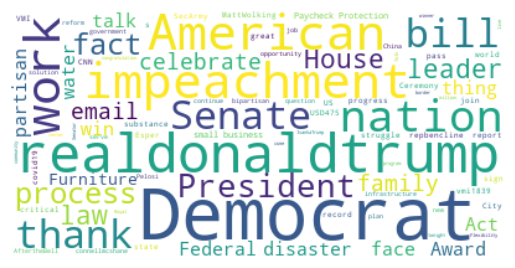

In [74]:
##### REPUBLIC
# now apply the function to all the columns in our dataframe
# ----------
# apply function to text object
RE_text = ' '.join(RE_tweets_part['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
RE_wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(RE_text)             # change the background color

# plot 
plt.imshow(RE_wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

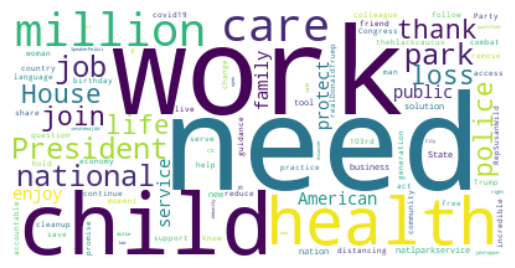

In [75]:
##### DEMOCRAT
# now apply the function to all the columns in our dataframe
# ----------
# apply function to text object
DE_text = ' '.join(DE_tweets_part['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
DE_wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(DE_text)             # change the background color

# plot 
plt.imshow(DE_wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

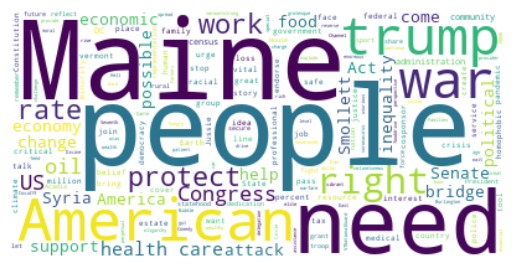

In [77]:
##### INDEPENDENT
# now apply the function to all the columns in our dataframe
# ----------
# apply function to text object
IN_text = ' '.join(IN_tweets_part['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
IN_wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(IN_text)             # change the background color

# plot 
plt.imshow(IN_wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

In [83]:
## create new feature columns with counts of # of characters and # of words
# ----------

# count number of characters
RE_tweets_part['text_len'] = RE_tweets_part['text_spell'].dropna().apply(len)
DE_tweets_part['text_len'] = DE_tweets_part['text_spell'].dropna().apply(len)
IN_tweets_part['text_len'] = IN_tweets_part['text_spell'].dropna().apply(len)


# count number of words
RE_tweets_part['word_count'] = RE_tweets_part['text_spell'].dropna().apply(lambda x: len(str(x).split()))
DE_tweets_part['word_count'] = DE_tweets_part['text_spell'].dropna().apply(lambda x: len(str(x).split()))
IN_tweets_part['word_count'] = IN_tweets_part['text_spell'].dropna().apply(lambda x: len(str(x).split()))

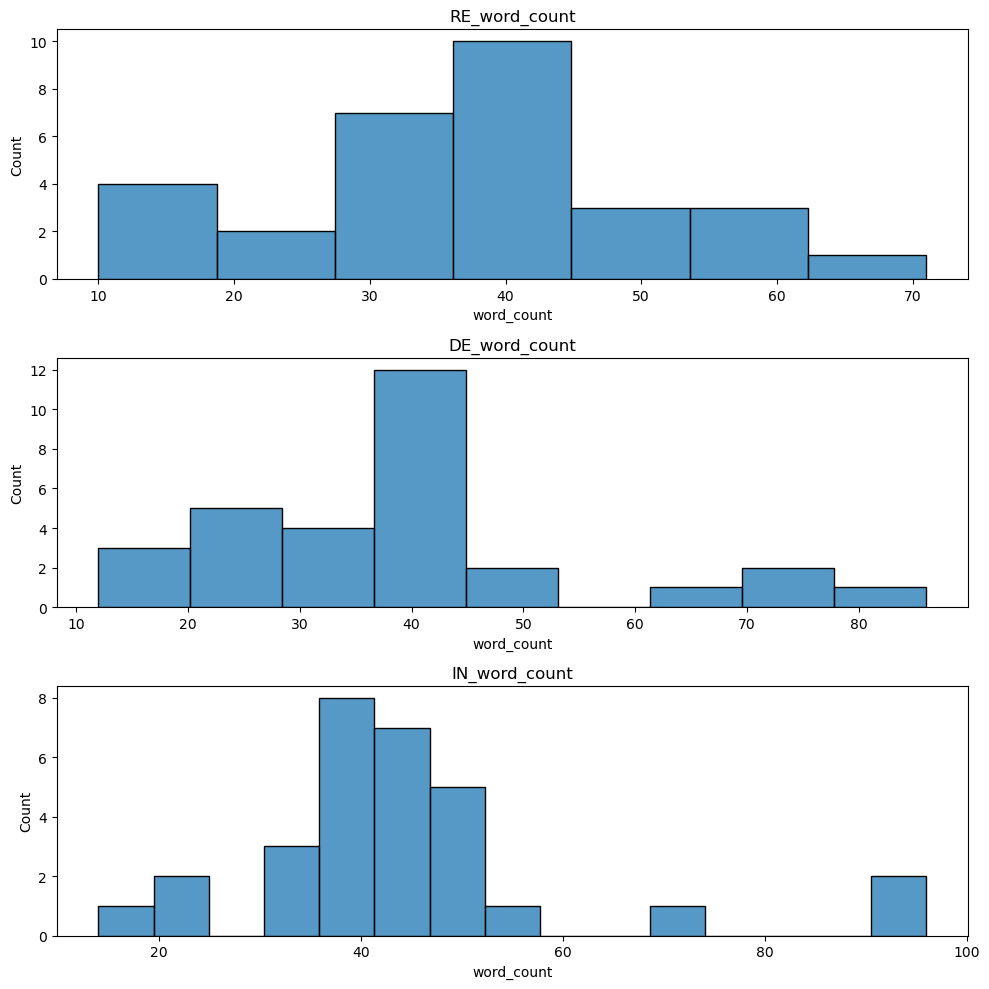

In [84]:
# 그래프 생성을 위한 figure와 axes 설정
fig, axs = plt.subplots(3, figsize=(10, 10))

# 첫 번째 그래프
sns.histplot(RE_tweets_part, x="word_count", ax=axs[0])
axs[0].set_title('RE_word_count')

# 두 번째 그래프
sns.histplot(DE_tweets_part, x="word_count", ax=axs[1])
axs[1].set_title('DE_word_count')

# 세 번째 그래프
sns.histplot(IN_tweets_part, x="word_count", ax=axs[2])
axs[2].set_title('IN_word_count')

# 그래프 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

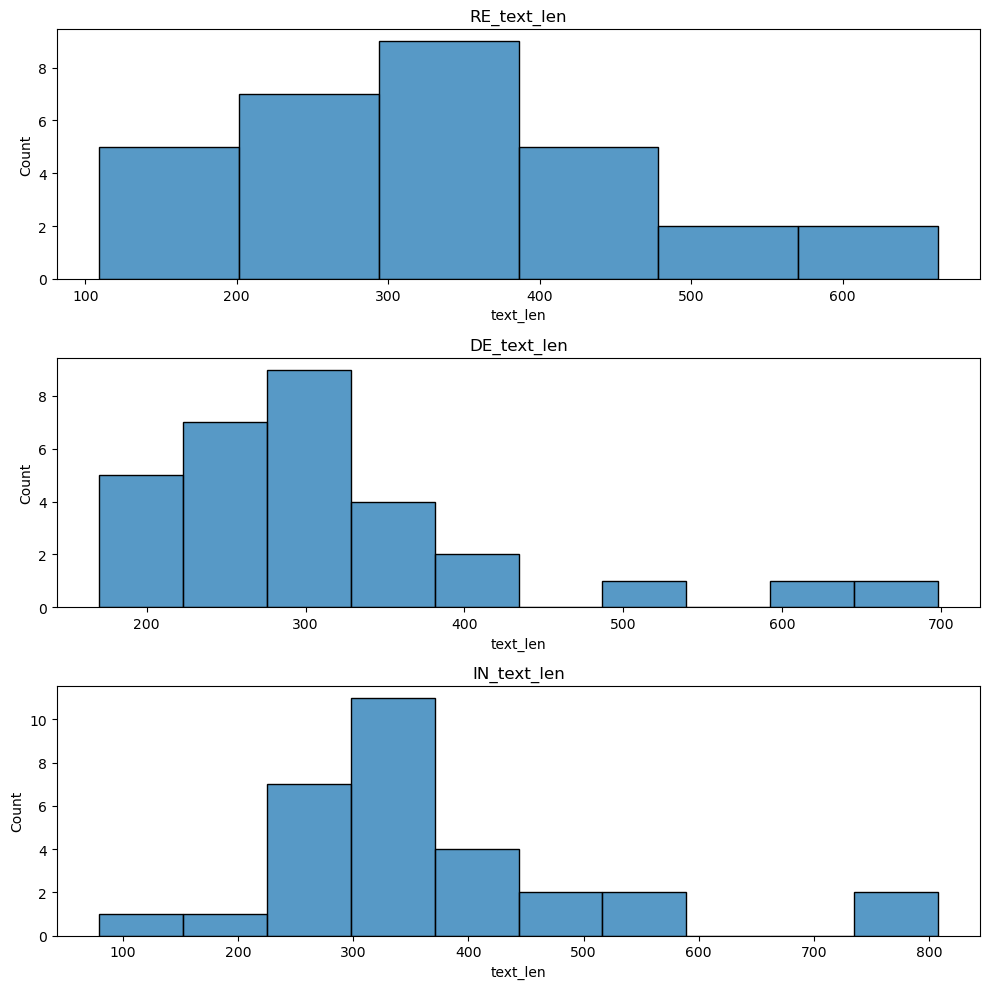

In [80]:
# 그래프 생성을 위한 figure와 axes 설정
fig, axs = plt.subplots(3, figsize=(10, 10))

# 첫 번째 그래프
sns.histplot(RE_tweets_part, x="text_len", ax=axs[0])
axs[0].set_title('RE_text_len')

# 두 번째 그래프
sns.histplot(DE_tweets_part, x="text_len", ax=axs[1])
axs[1].set_title('DE_text_len')

# 세 번째 그래프
sns.histplot(IN_tweets_part, x="text_len", ax=axs[2])
axs[2].set_title('IN_text_len')

# 그래프 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [81]:
RE_tweets_part['tokens_join'] = RE_tweets_part['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")
DE_tweets_part['tokens_join'] = DE_tweets_part['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")
IN_tweets_part['tokens_join'] = IN_tweets_part['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")

RE_tweets_part['polarity'] = RE_tweets_part['tokens_join'].map(lambda text: TextBlob(text).sentiment.polarity)
DE_tweets_part['polarity'] = DE_tweets_part['tokens_join'].map(lambda text: TextBlob(text).sentiment.polarity)
IN_tweets_part['polarity'] = IN_tweets_part['tokens_join'].map(lambda text: TextBlob(text).sentiment.polarity)

RE_tweets_part['subjectivity'] = RE_tweets_part['tokens_join'].map(lambda text: TextBlob(text).sentiment.subjectivity)
DE_tweets_part['subjectivity'] = DE_tweets_part['tokens_join'].map(lambda text: TextBlob(text).sentiment.subjectivity)
IN_tweets_part['subjectivity'] = IN_tweets_part['tokens_join'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [ ]:
RE_tweets_part.head(n=10)

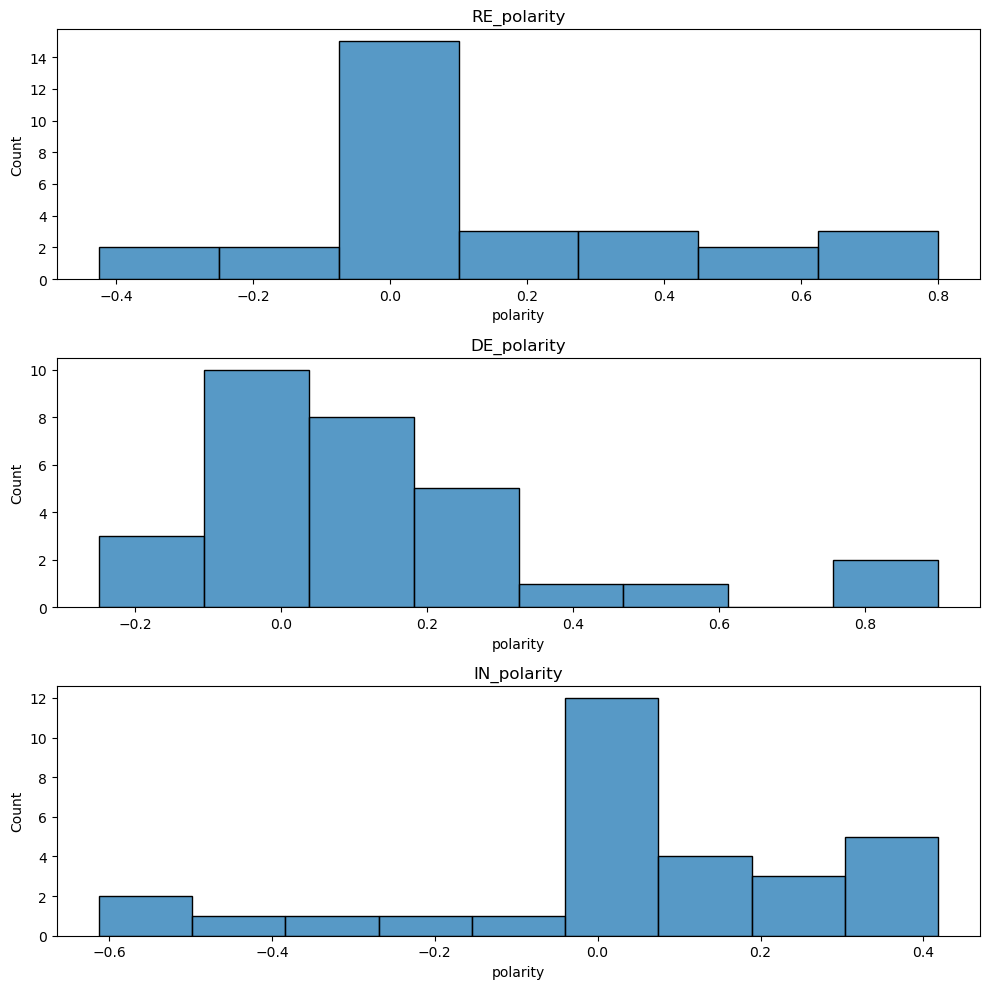

In [82]:
# 그래프 생성을 위한 figure와 axes 설정
fig, axs = plt.subplots(3, figsize=(10, 10))

# 첫 번째 그래프
sns.histplot(RE_tweets_part, x="polarity", ax=axs[0])
axs[0].set_title('RE_polarity')

# 두 번째 그래프
sns.histplot(DE_tweets_part, x="polarity", ax=axs[1])
axs[1].set_title('DE_polarity')

# 세 번째 그래프
sns.histplot(IN_tweets_part, x="polarity", ax=axs[2])
axs[2].set_title('IN_polarity')

# 그래프 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
print(RE_tweets_part['polarity'].describe(), DE_tweets_part['polarity'].describe(), IN_tweets_part['polarity'].describe())

In [ ]:
# 그래프 생성을 위한 figure와 axes 설정
fig, axs = plt.subplots(3, figsize=(10, 10))

# 첫 번째 그래프
sns.histplot(RE_tweets_part, x="subjectivity", ax=axs[0])
axs[0].set_title('RE_subjectivity')

# 두 번째 그래프
sns.histplot(DE_tweets_part, x="subjectivity", ax=axs[1])
axs[1].set_title('DE_subjectivity')

# 세 번째 그래프
sns.histplot(IN_tweets_part, x="subjectivity", ax=axs[2])
axs[2].set_title('IN_subjectivity')

# 그래프 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
RE_tweets_polarity = RE_tweets_part[RE_tweets_part['polarity']!= 0]
DE_tweets_polarity = DE_tweets_part[DE_tweets_part['polarity']!= 0]
IN_tweets_polarity = IN_tweets_part[IN_tweets_part['polarity']!= 0]

In [ ]:
print(RE_tweets_polarity['polarity'].describe(), DE_tweets_polarity['polarity'].describe(), IN_tweets_polarity['polarity'].describe())

In [ ]:
print(RE_tweets_part['subjectivity'].describe(), DE_tweets_part['subjectivity'].describe(), IN_tweets_part['subjectivity'].describe())

In [ ]:
fig, axs = plt.subplots(3, figsize=(10, 10))

# 1st graph
plt.subplot(3, 1, 1)
plt.scatter(RE_tweets_part['polarity'], RE_tweets_part['subjectivity'])
plt.title('RE polarity and subjectivity')

# 2nd graph
plt.subplot(3, 1, 2)
plt.scatter(DE_tweets_part['polarity'], DE_tweets_part['subjectivity'])
plt.title('DE polarity and subjectivity')

# 3rd graph
plt.subplot(3, 1, 3)
plt.scatter(IN_tweets_part['polarity'], IN_tweets_part['subjectivity'])
plt.title('IN polarity and subjectivity')

# 그래프 보여주기
plt.tight_layout()
plt.show()

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [ ]:
... 

### EDA 2

In [ ]:
...

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.